<a href="https://colab.research.google.com/github/tomerlieber/Multi-Label-Emotion-Regression/blob/main/Emotion%20Regression%20using%20LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural emotion detection using LSTM.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from random import sample
import numpy as np


The dataset that we work on is called EmoBank, which comprises 10k sentences balancing multiple genres.

It's hosted on GitHub in this repo: https://github.com/JULIELab/EmoBank

Load the dataset into a pandas dataframe.

## Loading EmoBank Dataset

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/JULIELab/EmoBank/master/corpus/emobank.csv')

train = df[df['split'] == 'train']
dev = df[df['split'] == 'dev']
test = df[df['split'] == 'test']

## Visualizing Dataset Distributions

### Arousal label distribution across traing, dev and test

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


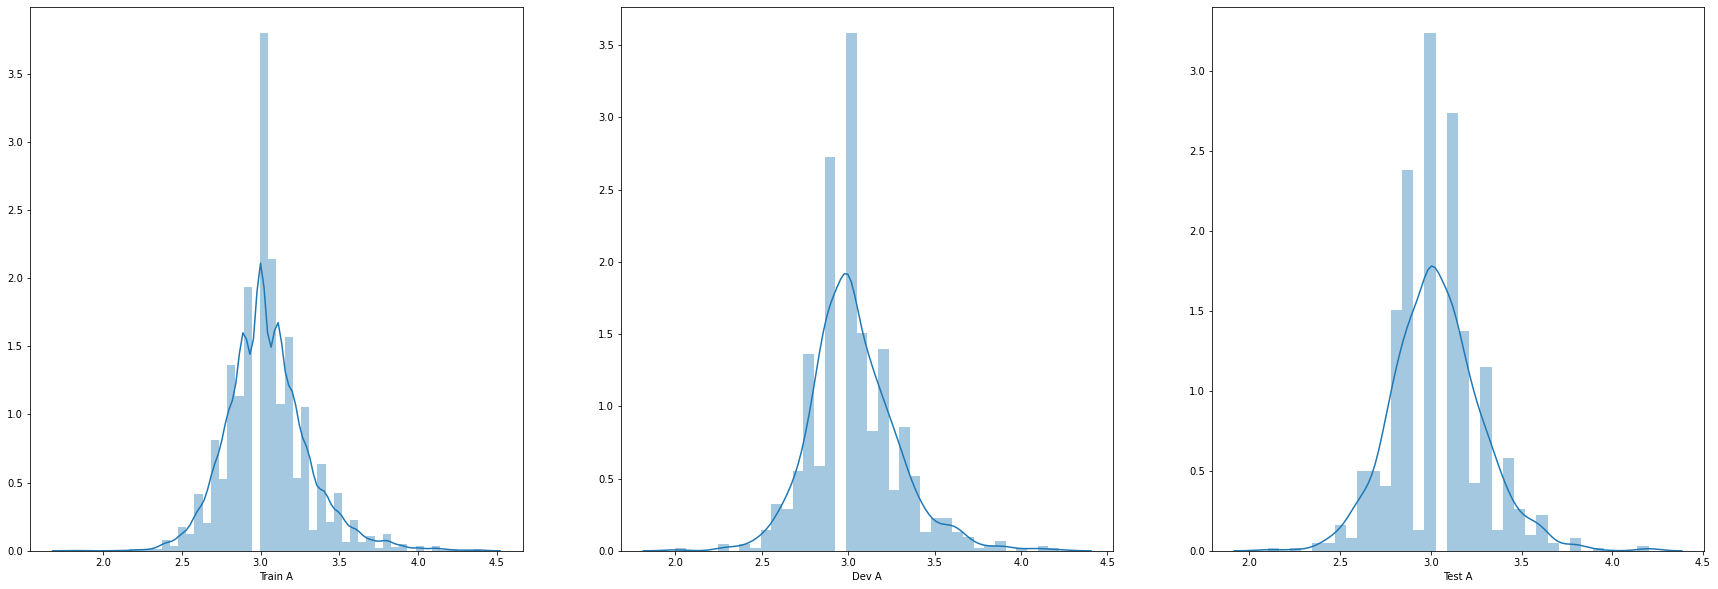

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(30,10))


sns.distplot(train['A'], kde=True, ax=axs[0], axlabel='Train A');
sns.distplot(dev['A'], kde=True,  ax=axs[1], axlabel='Dev A');
sns.distplot(test['A'], kde=True,  ax=axs[2], axlabel='Test A');


### Valence label distribution across traing, dev and test

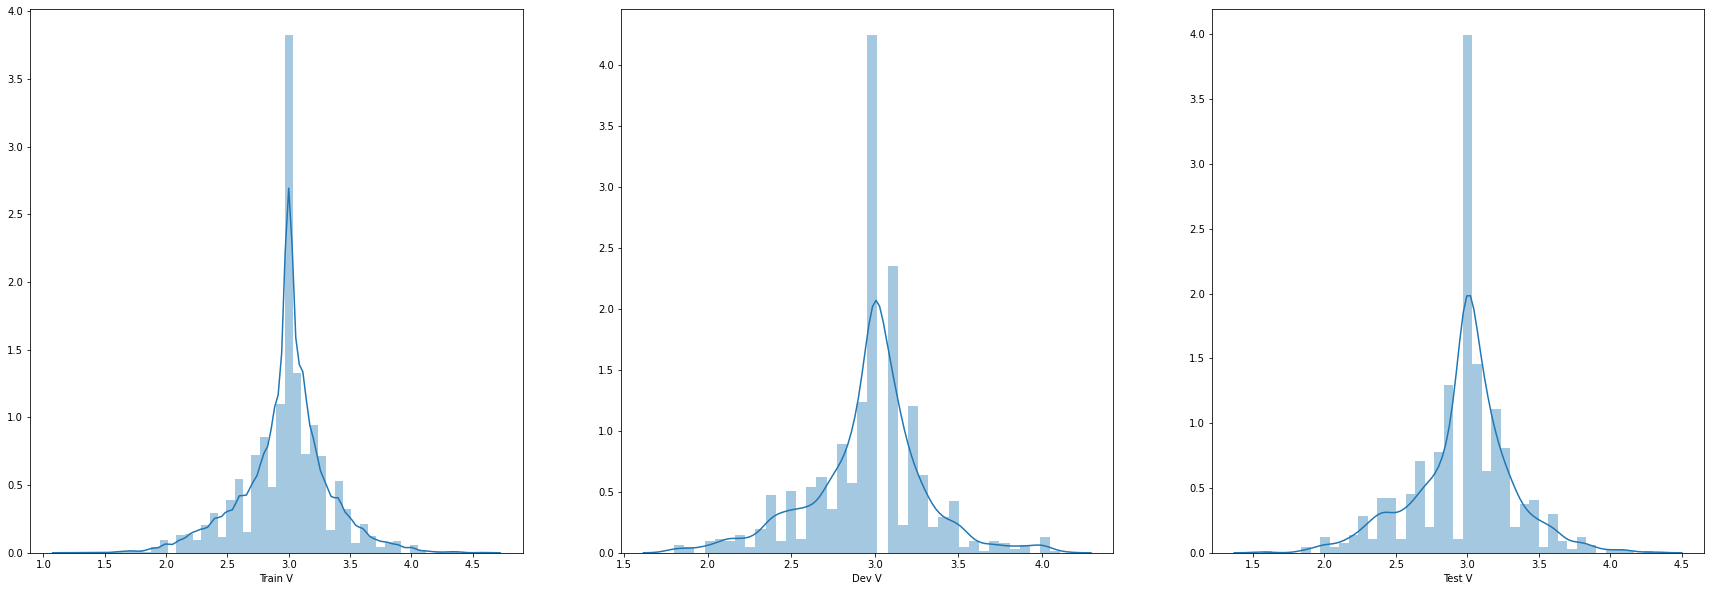

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))


sns.distplot(train['V'], kde=True, ax=axs[0], axlabel='Train V');
sns.distplot(dev['V'], kde=True,  ax=axs[1], axlabel='Dev V');
sns.distplot(test['V'], kde=True,  ax=axs[2], axlabel='Test V');


### Dominance label distribution across traing, dev and test

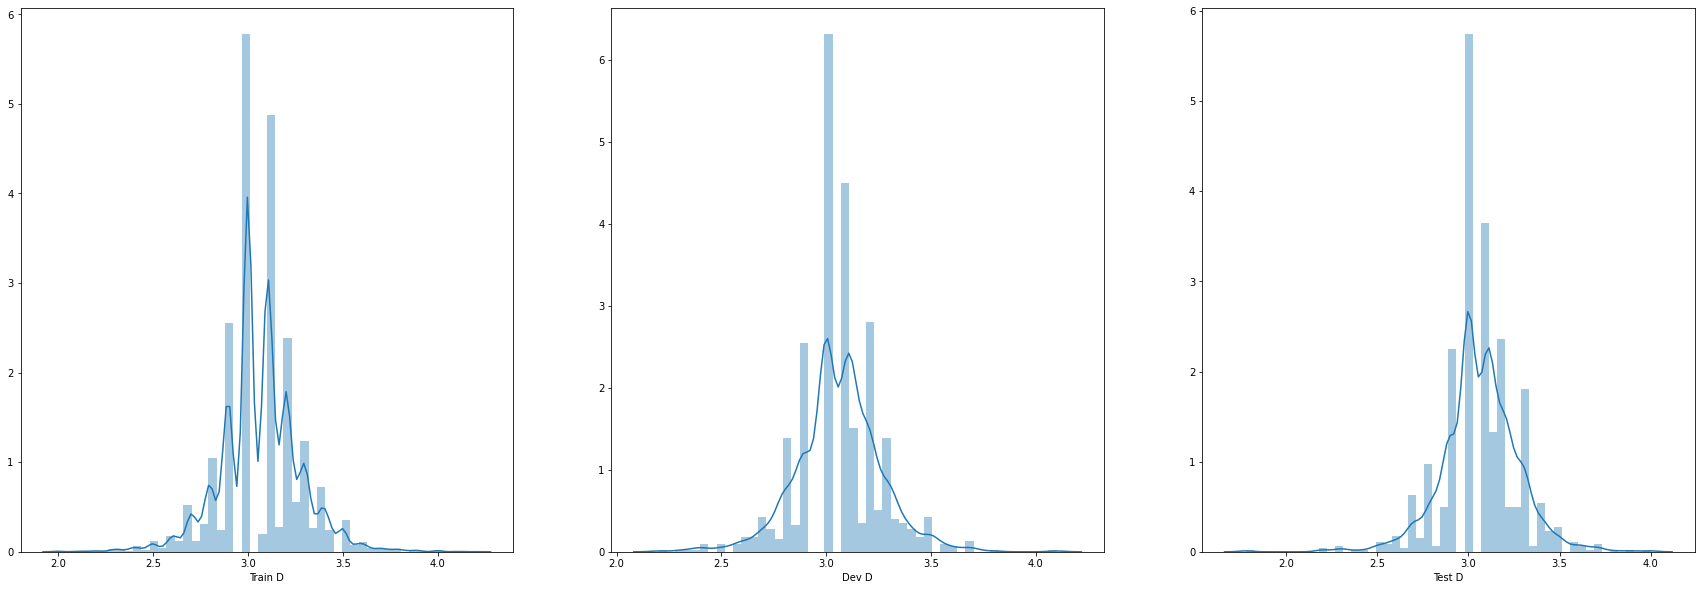

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(30,10))


sns.distplot(train['D'], kde=True, ax=axs[0], axlabel='Train D');
sns.distplot(dev['D'], kde=True,  ax=axs[1], axlabel='Dev D');
sns.distplot(test['D'], kde=True,  ax=axs[2], axlabel='Test D');



### Extracting counts, means and std for all labels to compare splits distributions

In [ ]:
print(train['A'].count(), dev['A'].count(), test['A'].count())
print(train['A'].mean(), dev['A'].mean(), test['A'].mean())
print(train['A'].std(), dev['A'].std(), test['A'].std())
print(train['V'].mean(), dev['V'].mean(), test['V'].mean())
print(train['V'].std(), dev['V'].std(), test['V'].std())
print(train['D'].mean(), dev['D'].mean(), test['D'].mean())
print(train['D'].std(), dev['D'].std(), test['D'].std())

8062 1000 1000
3.0440647482014414 3.0312499999999996 3.033940000000003
0.2621843624169322 0.2510565013435559 0.24594178938066533
2.978342842967003 2.9619600000000026 2.9780899999999977
0.3502044098686917 0.3399239719506516 0.3453431826659013
3.06270776482264 3.0614399999999984 3.064529999999992
0.21055423035844703 0.20190763505398515 0.21038593427637078


### Extracting extreme samples for better understanding of the labels

In [ ]:
print(train[train['V']==train['V'].max()])
print(train[train['V']==train['V'].min()])

                      id  split    V    A    D                          text
9595  vampires_4446_4474  train  4.6  4.3  3.7  lol Wonderful Simply Superb!
                                          id  split    V    A    D        text
1146  A_defense_of_Michael_Moore_12034_12044  train  1.2  4.2  3.8  "Fuck you"


In [ ]:
print(train[train['A']==train['A'].max()])
print(train[train['A']==train['A'].min()])

                                id  ...                              text
7787  captured_moments_28728_28752  ...          "My God, yes, yes, yes!"
7949    captured_moments_5506_5538  ...  I hate it, despise it, abhor it!
8269             detroit_4401_4433  ...  DETROIT POLICE ARE WATCHING YOU!

[3 rows x 6 columns]
                              id  ...                                        text
3535  Nathans_Bylichka_2070_2112  ...  I was feeling calm and private that night.

[1 rows x 6 columns]


In [ ]:
train[train['id']=='Nathans_Bylichka_2070_2112']
#train[train['id']=='captured_moments_28728_28752']

,id,split,V,A,D,text
3535,Nathans_Bylichka_2070_2112,train,3.1,1.8,3.1,I was feeling calm and private that night.


In [ ]:
print(train[train['D']==train['D'].max()])
print(train[train['D']==train['D'].min()])

                        id  split    V    A    D  text
8056  defenders5_3431_3435  train  1.7  3.9  4.2  “NO”
                                id  ...                                               text
4183  Nathans_Bylichka_56572_56622  ...  Hands closed on my neck and I felt my spine cr...
8439        easy_money_15382_15465  ...  I figure it can't be worse than the lethal inj...
9134  hotel-california_34025_34057  ...                   Failing all else, I'd suffocate.

[3 rows x 6 columns]


In [ ]:
#train[train['id']=='defenders5_3431_3435']
train[train['id']=='Nathans_Bylichka_56572_56622']

,id,split,V,A,D,text
4183,Nathans_Bylichka_56572_56622,train,1.9,3.8,2.0,Hands closed on my neck and I felt my spine cr...


## Tokenizing the Data Set

In [ ]:
UNK_TOKEN = 0

class Vocab:
    def __init__(self):
        self.word2id = {"__unk__": UNK_TOKEN}
        self.id2word = {UNK_TOKEN: "__unk__"}
        self.n_words = 1
        
    def index_words(self, words, is_train):
      word_indexes = [self.index_word(w, is_train) for w in words]
      return word_indexes

    def index_word(self, w, is_train):
        if (w not in self.word2id):
          if (is_train==True):
            self.word2id[w] = self.n_words
            self.id2word[self.n_words] = w
            self.n_words += 1
            return self.word2id[w]
          else:
            return UNK_TOKEN
        else:
          return self.word2id[w]

In [ ]:
import spacy
en = spacy.load('en')

def tokenize_data(sentences):
    data = []
    for index, sentence in sentences.iterrows():
      words = []
      labels = []

      for word in en.tokenizer(sentence.text):
        words.append(word.string)
      labels = (sentence.V, sentence.A, sentence.D)

      data.append((words, labels))
      
    return data

train_tokens = tokenize_data(train)
dev_tokens = tokenize_data(dev)
test_tokens = tokenize_data(test)

In [ ]:
vocab = Vocab()

def prepare_data(data, vocab, is_train=False):
    data_sequences = []
    
    for sentence_lists in data:
      encoded_words = vocab.index_words(sentence_lists[0], is_train)

      data_sequences.append((encoded_words, sentence_lists[1]))

    return data_sequences, vocab

train_sequences, vocab = prepare_data(train_tokens, vocab, True)
dev_sequences, vocab = prepare_data(dev_tokens, vocab)
test_sequences, vocab = prepare_data(test_tokens, vocab)

## Building the Model - LSTM

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers, directions, embedding_weights=None, freeze_embedding=False):
        super(LSTMNet, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.directions = directions
        
        if (embedding_weights is not None):
          self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze_embedding)
        else:
          self.embedding = nn.Embedding(input_size, embedding_size)

        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, bidirectional=(directions==2))
        self.out = nn.Linear(hidden_size*self.directions, output_size)
    
    def forward(self, input_sentence, hidden):
      #input => len(sequence)XVocabulary/index, output=> len(sequence)XembeddingSize
      embedded = self.embedding(input_sentence).view(len(input_sentence), 1, self.embedding_size)

      #input => len(sequence)XembeddingSize, output=> len(input_sequence)X(hidden_size*num_directions)
      output, hidden = self.lstm(embedded, hidden)

      #input=> len(input_sequence)X(hidden_size*num_directions), output=> len(input_sequence)Xoutputsize
      output = self.out(output)
      output = output[len(input_sentence)-1][0]

      return output, hidden

    def init_hidden(self):
      return (torch.zeros(self.n_layers * self.directions, 1, self.hidden_size).cuda(),
              torch.zeros(self.n_layers * self.directions, 1, self.hidden_size).cuda())

### Evaluation method - MSE

In [ ]:
def eval_model(data, model, caption):
  criterion = torch.nn.MSELoss()
  loss = 0
  for sequence in data:
    sequence_tensor = torch.LongTensor(sequence[0]).cuda()
    label_tensor = torch.FloatTensor(sequence[1]).cuda()
    output, hideen = model(sequence_tensor, model.init_hidden())
    loss += criterion(output.view(1,3), label_tensor.view(1,3))
  print(caption, 'Loss: %.4f' % (loss / 100))

  # should be be 1000
  return loss / 100


### Train loop

In [ ]:

def train_loop(model, n_epochs, data_sequences, lr):
  dev_loss = []

  criterion = torch.nn.MSELoss()

  optimizer = optim.Adam(model.parameters(), lr=lr)
  loss = 0

  for e in range(1, n_epochs + 1):

    model.train()

    # shuffle the data before starting a new epoch
    data_sequences_shuff = sample(data_sequences, len(data_sequences))

    for counter, sequence in enumerate(data_sequences_shuff):

      # zero gradients
      optimizer.zero_grad()

      # creating a tensor for the input sentence
      sequence_tensor = torch.LongTensor(sequence[0]).cuda()
      label_tensor = torch.FloatTensor(sequence[1]).cuda()

      # initialize the first hidden vector
      hidden = model.init_hidden()

      # forward
      output, hidden = model(sequence_tensor, hidden)

      # loss
      sentence_loss = criterion(output.view(1,3), label_tensor.view(1,3))

      # running backward
      sentence_loss.backward()

      # updating weights
      optimizer.step()

      loss += sentence_loss
    print('Epoch: %d, Current Loss: %.4f' % (e, loss / 100))
    loss = 0
    
    model.eval()

    dev_loss.append(eval_model(dev_sequences, model, 'Dev:').item())
    print(dev_loss)
  return dev_loss



### Hyper paramater tuninig vs the dev set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import itertools
import operator
import os


epochs = [9]#3, 5, 7, 9]
lrs = [0.0001, 0.001, 0.01]
hidden_size = [500, 800]
n_layers = [1, 2, 3]
n_directions = [1,2]

results = {}

saved = open('/content/drive/My Drive/Colab Notebooks/model_outputs.txt', mode='r').read().split('\n')
for save in saved:
  splits = save.split(', ')
  if (len(splits) > 1):
    if (len(splits)==6):
      hpt = (float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), int(splits[4]))
      results[hpt] = float(splits[5])
    else:
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 3)] = float(splits[7])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 5)] = float(splits[9])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 7)] = float(splits[11])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 9)] = float(splits[13])

configurations = []
for element in itertools.product(lrs, hidden_size, n_layers, n_directions, epochs):
    configurations.append(element)

for config in configurations:
  print(config)

  if config not in results:
    model = LSTMNet(input_size=vocab.n_words, embedding_size=300, hidden_size=config[1], output_size=3, n_layers=config[2], directions=config[3]).cuda()
    dev_loss = train_loop(model, n_epochs=config[4], data_sequences=train_sequences, lr=config[0])
    results[config] = dev_loss

    curr_config =  ', '.join([str(x) for x in config])
    curr_config += ', ' + ', '.join([str(x) for x in dev_loss])
    output = open('/content/drive/My Drive/Colab Notebooks/model_outputs.txt', mode='a')
    output.write(curr_config)
    output.write("\n")
    output.close()
  else:
    print('config in results. Skip')

(0.0001, 500, 1, 1, 9)
config in results. Skip
(0.0001, 500, 1, 2, 9)
config in results. Skip
(0.0001, 500, 2, 1, 9)
config in results. Skip
(0.0001, 500, 2, 2, 9)
config in results. Skip
(0.0001, 500, 3, 1, 9)
config in results. Skip
(0.0001, 500, 3, 2, 9)
config in results. Skip
(0.0001, 800, 1, 1, 9)
config in results. Skip
(0.0001, 800, 1, 2, 9)
config in results. Skip
(0.0001, 800, 2, 1, 9)
config in results. Skip
(0.0001, 800, 2, 2, 9)
config in results. Skip
(0.0001, 800, 3, 1, 9)
config in results. Skip
(0.0001, 800, 3, 2, 9)
config in results. Skip
(0.001, 500, 1, 1, 9)
config in results. Skip
(0.001, 500, 1, 2, 9)
config in results. Skip
(0.001, 500, 2, 1, 9)
config in results. Skip
(0.001, 500, 2, 2, 9)
config in results. Skip
(0.001, 500, 3, 1, 9)
config in results. Skip
(0.001, 500, 3, 2, 9)
config in results. Skip
(0.001, 800, 1, 1, 9)
config in results. Skip
(0.001, 800, 1, 2, 9)
config in results. Skip
(0.001, 800, 2, 1, 9)
config in results. Skip
(0.001, 800, 2, 2, 9)


In [ ]:
best_config = min(results.items(), key=operator.itemgetter(1))[0]
print('the best config is:', best_config, 'with results:', results[best_config])

the best config is: (0.0001, 500, 3, 2, 3) with results: 0.6592748761177063


In [ ]:
model = LSTMNet(input_size=vocab.n_words, embedding_size=300, hidden_size=best_config[1], output_size=3, n_layers=best_config[2], directions=best_config[3]).cuda()
dev_loss = train_loop(model, n_epochs=best_config[4], data_sequences=train_sequences, lr=best_config[0])

Epoch: 1, Current Loss: 10.5684
Dev: Loss: 0.7417
[0.7416608333587646]
Epoch: 2, Current Loss: 6.2048
Dev: Loss: 0.7228
[0.7416608333587646, 0.7228326201438904]
Epoch: 3, Current Loss: 5.7742
Dev: Loss: 0.6770
[0.7416608333587646, 0.7228326201438904, 0.6770237684249878]


In [ ]:
eval_model(test_sequences, model, 'Test:').item()

Test: Loss: 0.6987


0.6986604928970337

In [ ]:
torch.save(model, '/content/drive/My Drive/Colab Notebooks/model_pickle')

In [ ]:
model1 = torch.load('/content/drive/My Drive/Colab Notebooks/model_pickle')
model1.eval()

LSTMNet(
  (embedding): Embedding(21283, 300)
  (lstm): LSTM(300, 500, num_layers=3, bidirectional=True)
  (out): Linear(in_features=1000, out_features=3, bias=True)
)

In [ ]:
eval_model(test_sequences, model1, 'Test:').item()

Test: Loss: 0.6987


0.698660671710968

### Same procedure but w/ Glove Embeddings

In [ ]:
def generate_glove_embeddings(glove_path, vocab):
  glove_embeddings = torch.zeros((vocab.n_words, 300)).cuda()
  glove_words = open(glove_path).read().split('\n')

  for line in glove_words:
    pair = line.split()
    if (len(pair)>1):
      word = pair[0]
      index = vocab.index_word(word, False)
      if (index != UNK_TOKEN):
        glove_embeddings[index] = torch.FloatTensor([float(value) for value in pair[1:]]).cuda()
  return glove_embeddings

glove_embeddings = generate_glove_embeddings('/content/drive/My Drive/glove.6B.300d.txt', vocab=vocab)

In [ ]:
glove_embeddings

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4235,  0.4836,  0.1053,  ..., -0.0612,  0.1208, -0.2513],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1831,  0.2821, -0.3080,  ...,  0.3388, -0.0912, -0.3682]],
       device='cuda:0')

In [ ]:
torch.any(glove_embeddings!=0, axis=1).sum()

tensor(5136, device='cuda:0')

In [ ]:
import itertools
import operator
import os


epochs = [9]
lrs = [0.0001, 0.001, 0.01]
hidden_size = [500, 800]
n_layers = [1, 2, 3]
n_directions = [1,2]

results = {}

saved = open('/content/drive/My Drive/embedding_model_outputs.txt', mode='r').read().split('\n')
for save in saved:
  splits = save.split(', ')
  if (len(splits) > 1):
    if (len(splits)==6):
      hpt = (float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), int(splits[4]))
      results[hpt] = float(splits[5])
    else:
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 1)] = float(splits[5])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 2)] = float(splits[6])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 3)] = float(splits[7])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 4)] = float(splits[8])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 5)] = float(splits[9])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 6)] = float(splits[10])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 7)] = float(splits[11])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 8)] = float(splits[12])
      results[(float(splits[0]), int(splits[1]), int(splits[2]), int(splits[3]), 9)] = float(splits[13])

configurations = []
for element in itertools.product(lrs, hidden_size, n_layers, n_directions, epochs):
    configurations.append(element)

for config in configurations:
  print(config)

  if config not in results:
    model = LSTMNet(input_size=vocab.n_words, embedding_size=300, hidden_size=config[1], output_size=3, n_layers=config[2], directions=config[3], embedding_weights=glove_embeddings, freeze_embedding=False).cuda()
    dev_loss = train_loop(model, n_epochs=config[4], data_sequences=train_sequences, lr=config[0])
    results[config] = dev_loss

    curr_config =  ', '.join([str(x) for x in config])
    curr_config += ', ' + ', '.join([str(x) for x in dev_loss])
    output = open('/content/drive/My Drive/embedding_model_outputs.txt', mode='a')
    output.write(curr_config)
    output.write("\n")
    output.close()
  else:
    print('config in results. Skip')

(0.0001, 500, 1, 1, 9)
config in results. Skip
(0.0001, 500, 1, 2, 9)
config in results. Skip
(0.0001, 500, 2, 1, 9)
config in results. Skip
(0.0001, 500, 2, 2, 9)
config in results. Skip
(0.0001, 500, 3, 1, 9)
config in results. Skip
(0.0001, 500, 3, 2, 9)
config in results. Skip
(0.0001, 800, 1, 1, 9)
config in results. Skip
(0.0001, 800, 1, 2, 9)
config in results. Skip
(0.0001, 800, 2, 1, 9)
config in results. Skip
(0.0001, 800, 2, 2, 9)
config in results. Skip
(0.0001, 800, 3, 1, 9)
config in results. Skip
(0.0001, 800, 3, 2, 9)
config in results. Skip
(0.001, 500, 1, 1, 9)
config in results. Skip
(0.001, 500, 1, 2, 9)
config in results. Skip
(0.001, 500, 2, 1, 9)
config in results. Skip
(0.001, 500, 2, 2, 9)
config in results. Skip
(0.001, 500, 3, 1, 9)
config in results. Skip
(0.001, 500, 3, 2, 9)
config in results. Skip
(0.001, 800, 1, 1, 9)
config in results. Skip
(0.001, 800, 1, 2, 9)
config in results. Skip
(0.001, 800, 2, 1, 9)
config in results. Skip
(0.001, 800, 2, 2, 9)


In [ ]:
best_config = min(results.items(), key=operator.itemgetter(1))[0]
print('the best config is:', best_config, 'with results:', results[best_config])

the best config is: (0.0001, 500, 1, 1, 6) with results: 0.6512441635131836


In [ ]:
model_embeddings = LSTMNet(input_size=vocab.n_words, embedding_size=300, hidden_size=best_config[1], output_size=3, n_layers=best_config[2], directions=best_config[3]).cuda()
dev_loss = train_loop(model_embeddings, n_epochs=best_config[4], data_sequences=train_sequences, lr=best_config[0])

In [ ]:
eval_model(test_sequences, model_embeddings, 'Test:').item()

Test: Loss: 0.7483


0.7482512593269348

In [ ]:
torch.save(model_embeddings, '/content/drive/My Drive/model_embeddings_pickle')

In [ ]:
model_embeddings = torch.load('/content/drive/My Drive/model_embeddings_pickle')
model_embeddings.eval()

LSTMNet(
  (embedding): Embedding(21283, 300)
  (lstm): LSTM(300, 500)
  (out): Linear(in_features=500, out_features=3, bias=True)
)

In [ ]:
eval_model(test_sequences, model_embeddings, 'Test:').item()

Test: Loss: 0.7536


0.7536317110061646

## Baseline Model

In [ ]:
class AVGModel(nn.Module):
    def __init__(self):
        super(AVGModel, self).__init__()
    
    def forward(self, input_sentence, hidden):
      return 3 * torch.ones(1, 3).cuda(), 0

    def init_hidden(self):
      return 0

In [ ]:
avg_model = AVGModel()
eval_model(test_sequences, avg_model, 'Test:').item()

Test: Loss: 0.7653


0.7652791142463684

In [ ]:
eval_model(dev_sequences, avg_model, 'dev:').item()


dev: Loss: 0.7511


0.7510786056518555